In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import ast
import os

/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/

In [25]:
# half_task_name = 'V11L12-038_A1_half_top5sv'
# rand_task_name = "V11L12-038_A1_rand_top5sv"
# rand = pd.read_csv(f"/lustre/groups/ml01/workspace/eirini/pipeline/data/reports/{rand_task_name}/merged_results.tsv", sep='\t')
# half = pd.read_csv(f"/lustre/groups/ml01/workspace/eirini/pipeline/data/reports/{half_task_name}/merged_results.tsv", sep='\t')

task = "V11L12-038_A1"
task_name = "V11L12-038_A1"
# task = 'neuro'
# task_name = "neuro"
# task = 'lipids'
# task_name = "lipids"



# half = pd.read_csv(f"/lustre/groups/ml01/workspace/eirini/pipeline/data/reports/{task}/merged_results.tsv", sep='\t')
rand = pd.read_csv(f"/lustre/groups/ml01/workspace/eirini/pipeline/data/reports/{task}_rand/merged_results.tsv", sep='\t')
half = pd.read_csv(f"/lustre/groups/ml01/workspace/eirini/pipeline/data/reports/{task}_half/merged_results.tsv", sep='\t')

merged_df = pd.concat([half, rand], ignore_index=True)

Heatmap of best performer per model and per feature selection for RMSE

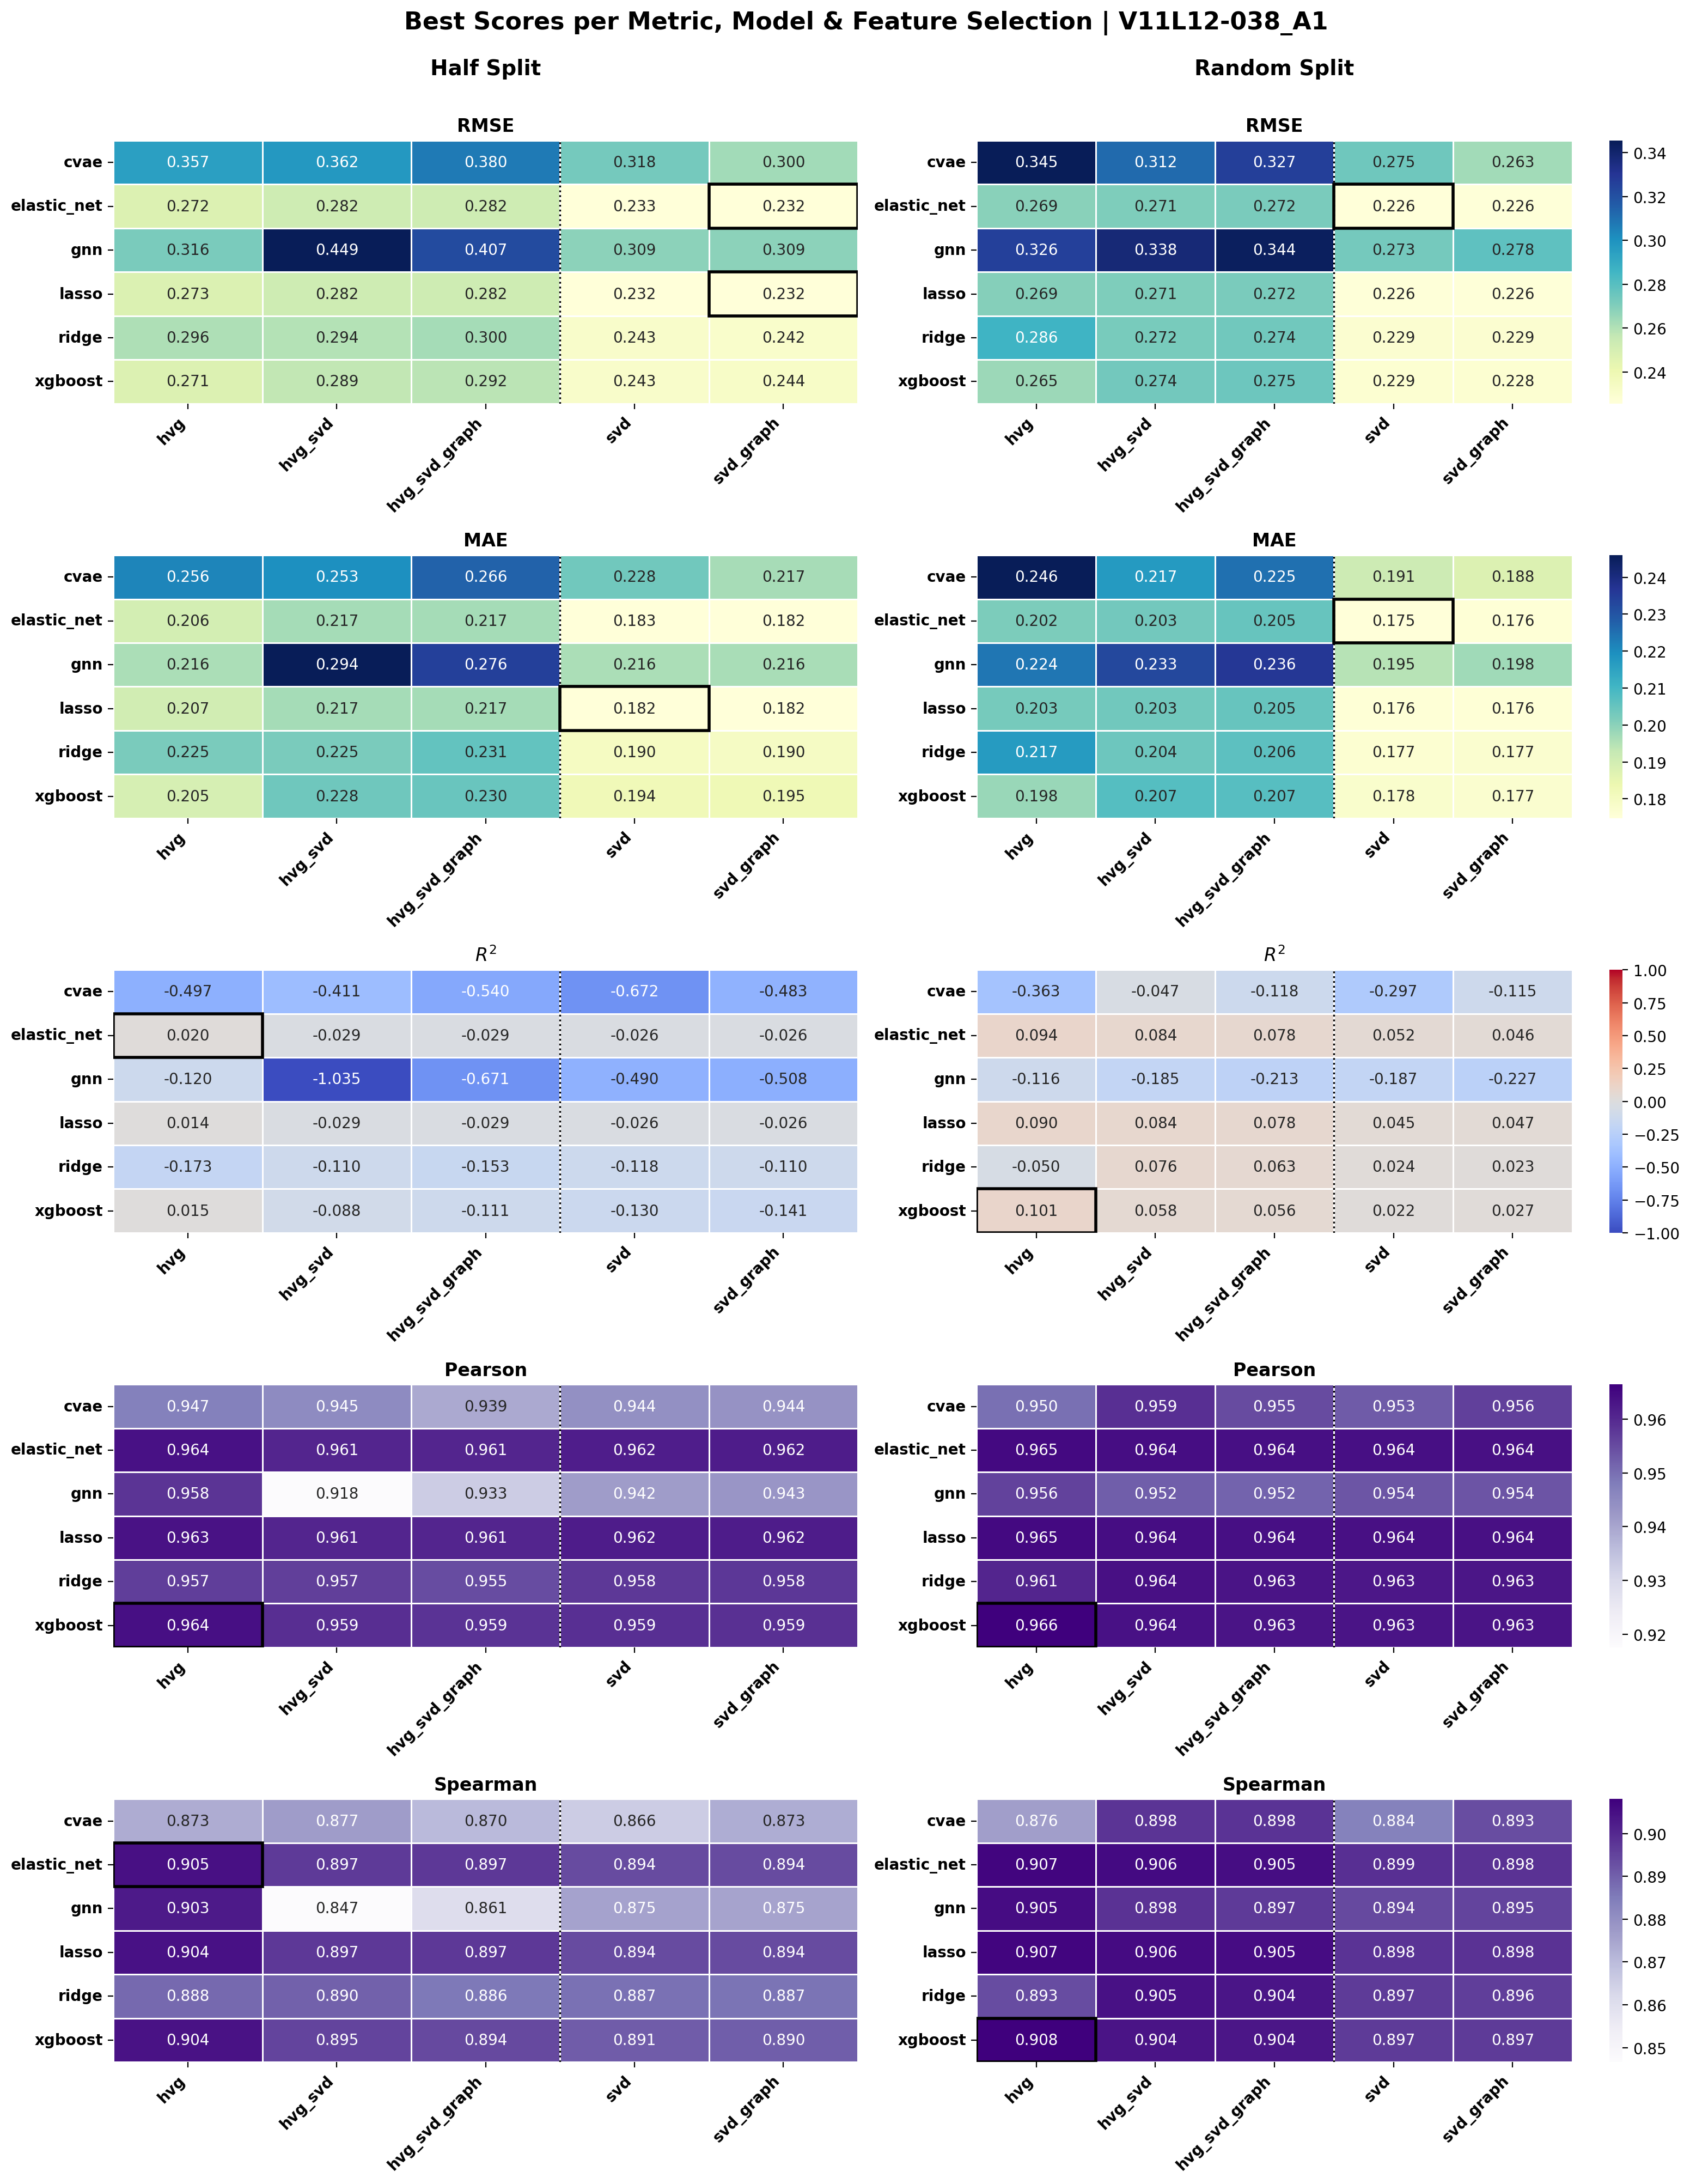

In [30]:
# --- Copy for safe plotting ---
plot_df = merged_df.copy()
plot_df = plot_df[plot_df["method_name"] != "linear"]
# --- Configuration ---
metrics = ['rmse', 'mae', 'r2', 'pearson', 'spearman']
feature_selection_methods = plot_df['featsel'].unique()
models = plot_df['method_name'].unique()

# --- Collect best scores per (model, featsel, metric, split) ---
summary = []

for split in ['half', 'rand']:
    split_df = plot_df[plot_df['task'].str.contains(split)]
    for model in models:
        for featsel in feature_selection_methods:
            model_fs_df = split_df[(split_df['method_name'] == model) & (split_df['featsel'] == featsel)]
            if model_fs_df.empty:
                continue
            for metric in metrics:
                best_val = model_fs_df[metric].min() if metric in ['rmse', 'mae'] else model_fs_df[metric].max()
                summary.append({
                    'model': model,
                    'featsel': featsel,
                    'metric': metric,
                    'split': split,
                    'best_score': best_val
                })

summary_df = pd.DataFrame(summary)

# --- Regenerate heatmap data without linear ---
heatmap_data = {}
for split in ['half', 'rand']:
    for metric in metrics:
        df_slice = summary_df[(summary_df['split'] == split) & (summary_df['metric'] == metric)]
        pivot = df_slice.pivot(index='model', columns='featsel', values='best_score')
        heatmap_data[(split, metric)] = pivot

import matplotlib.pyplot as plt
import seaborn as sns

# --- Set up grid ---
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20), dpi=200)
plt.subplots_adjust(hspace=0.6, wspace=0.3)

# --- Color scaling ---
vmin_r2, vmax_r2 = -1, 1
metric_titles = {
    'rmse': 'RMSE',
    'mae': 'MAE',
    'r2': r'$R^2$',
    'pearson': 'Pearson',
    'spearman': 'Spearman'
}

# Compute correlation-specific limits dynamically
metric_vmin_vmax = {}
for metric in ['pearson', 'spearman']:
    vals = summary_df[summary_df['metric'] == metric]['best_score']
    metric_vmin_vmax[metric] = (vals.min(), vals.max())


# --- Plot ---
for i, metric in enumerate(metrics):
    for j, split in enumerate(['half', 'rand']):
        ax = axes[i, j]
        data = heatmap_data[(split, metric)]

        # Select colormap
        if metric in ['rmse', 'mae']:
            cmap = "YlGnBu"
            vmin, vmax = None, None
        elif metric == 'r2':
            cmap = "coolwarm"
            vmin, vmax = vmin_r2, vmax_r2
        else:
            cmap = "Purples"
            vmin, vmax = metric_vmin_vmax[metric]


        # Plot
        sns.heatmap(data, ax=ax, annot=True, fmt=".3f", cmap=cmap,
                    linewidths=0.5, vmin=vmin, vmax=vmax,
                    cbar=(j == 1),  # only on the right
                    xticklabels=True, yticklabels=True)
        
        # Highlight best performer
        if metric in ['rmse', 'mae']:
            best_val = data.min().min()
            coords = list(zip(*((data == best_val).values).nonzero()))
        else:
            best_val = data.max().max()
            coords = list(zip(*((data == best_val).values).nonzero()))

        for (y, x) in coords:
            ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='black', linewidth=2))


        # Bold axis labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontweight="bold", fontsize=10)
        ax.set_yticklabels(ax.get_yticklabels(), fontweight="bold", fontsize=10)

        # Metric title per heatmap
        ax.set_title(metric_titles[metric], fontsize=12, fontweight="bold")

        # Add vertical dotted line between hvg and svd-style
        if 'hvg_svd' in data.columns and 'svd' in data.columns:
            svd_index = list(data.columns).index('svd')
            ax.axvline(svd_index, color='black', linestyle=':', linewidth=1.2)

        ax.set_xlabel("")
        ax.set_ylabel("")

# --- Add split titles above columns manually ---
axes[0, 0].annotate("Half Split", xy=(0.5, 1.25), xycoords='axes fraction',
                    ha='center', fontsize=14, fontweight='bold')
axes[0, 1].annotate("Random Split", xy=(0.5, 1.25), xycoords='axes fraction',
                    ha='center', fontsize=14, fontweight='bold')

# --- Suptitle ---
plt.suptitle(f"Best Scores per Metric, Model & Feature Selection | {task_name}", fontsize=16, fontweight="bold", y=1.0)
plt.tight_layout()
# plt.savefig(f"/lustre/groups/ml01/workspace/eirini/thesis_plots/viz/{task_name}_bp_fs_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()


In [16]:
merged_df

rmse       mae        r2   pearson  spearman  \
0    0.722457  0.587597 -0.182062  0.249730  0.275794   
1    0.773812  0.629346 -0.354543  0.221712  0.246373   
2    0.702351  0.572544 -0.120036  0.288949  0.307419   
3    0.728115  0.593280 -0.199749  0.249369  0.270327   
4    0.692008  0.568372 -0.087148  0.328599  0.336858   
..        ...       ...       ...       ...       ...   
644  0.886276  0.648787 -0.597183  0.418725  0.487228   
645  0.837535  0.644457 -0.437709  0.381977  0.412835   
646  0.752380  0.583211 -0.158518  0.467964  0.479862   
647  0.861442  0.611694 -0.534306  0.424352  0.512267   
648  0.981089  0.717387 -0.926038  0.397137  0.444221   

                          task method_name    featsel  \
0    V11L12-038_A1_half_top5sv     xgboost  svd_graph   
1    V11L12-038_A1_half_top5sv     xgboost  svd_graph   
2    V11L12-038_A1_half_top5sv     xgboost  svd_graph   
3    V11L12-038_A1_half_top5sv     xgboost  svd_graph   
4    V11L12-038_A1_half_top5sv     xgboost  svd_graph   
..                         ...         ...        ...   
644  V11L12-038_A1_rand_top5sv         gnn  svd_graph   
645  V11L12-038_A1_rand_top5sv         gnn  svd_graph   
646  V11L12-038_A1_rand_top5sv         gnn  svd_graph   
647  V11L12-038_A1_rand_top5sv         gnn  svd_graph   
648  V11L12-038_A1_rand_top5sv         gnn  svd_graph   

                                         method_params        hash  
0    {'alpha': 10, 'lambda': 55, 'max_depth': 6, 'l...  858778ec01  
1    {'alpha': 0, 'lambda': 0, 'max_depth': 4, 'lea...  595c2d0c91  
2    {'alpha': 10, 'lambda': 50, 'max_depth': 5, 'l...  0971a58a5d  
3    {'alpha': 15, 'lambda': 40, 'max_depth': 5, 'l...  76953cf16c  
4    {'alpha': 50, 'lambda': 100, 'max_depth': 3, '...  0c7dc31c7f  
..                                                 ...         ...  
644  {'hidden_dim': 896, 'lr': 0.0001, 'epochs': 40...  6a51569af0  
645  {'hidden_dim': 640, 'lr': 0.0003, 'epochs': 27...  703b1405da  
646  {'hidden_dim': 512, 'lr': 0.0002, 'epochs': 25...  c52573367b  
647  {'hidden_dim': 1024, 'lr': 0.00012, 'epochs': ...  f2511467c6  
648  {'hidden_dim': 768, 'lr': 0.00018, 'epochs': 3...  bcb3b5a352  

[649 rows x 10 columns]

In [21]:
merged_df

rmse       mae        r2   pearson  spearman  \
0    0.722457  0.587597 -0.182062  0.249730  0.275794   
1    0.773812  0.629346 -0.354543  0.221712  0.246373   
2    0.702351  0.572544 -0.120036  0.288949  0.307419   
3    0.728115  0.593280 -0.199749  0.249369  0.270327   
4    0.692008  0.568372 -0.087148  0.328599  0.336858   
..        ...       ...       ...       ...       ...   
644  0.886276  0.648787 -0.597183  0.418725  0.487228   
645  0.837535  0.644457 -0.437709  0.381977  0.412835   
646  0.752380  0.583211 -0.158518  0.467964  0.479862   
647  0.861442  0.611694 -0.534306  0.424352  0.512267   
648  0.981089  0.717387 -0.926038  0.397137  0.444221   

                          task method_name    featsel  \
0    V11L12-038_A1_half_top5sv     xgboost  svd_graph   
1    V11L12-038_A1_half_top5sv     xgboost  svd_graph   
2    V11L12-038_A1_half_top5sv     xgboost  svd_graph   
3    V11L12-038_A1_half_top5sv     xgboost  svd_graph   
4    V11L12-038_A1_half_top5sv     xgboost  svd_graph   
..                         ...         ...        ...   
644  V11L12-038_A1_rand_top5sv         gnn  svd_graph   
645  V11L12-038_A1_rand_top5sv         gnn  svd_graph   
646  V11L12-038_A1_rand_top5sv         gnn  svd_graph   
647  V11L12-038_A1_rand_top5sv         gnn  svd_graph   
648  V11L12-038_A1_rand_top5sv         gnn  svd_graph   

                                         method_params        hash  
0    {'alpha': 10, 'lambda': 55, 'max_depth': 6, 'l...  858778ec01  
1    {'alpha': 0, 'lambda': 0, 'max_depth': 4, 'lea...  595c2d0c91  
2    {'alpha': 10, 'lambda': 50, 'max_depth': 5, 'l...  0971a58a5d  
3    {'alpha': 15, 'lambda': 40, 'max_depth': 5, 'l...  76953cf16c  
4    {'alpha': 50, 'lambda': 100, 'max_depth': 3, '...  0c7dc31c7f  
..                                                 ...         ...  
644  {'hidden_dim': 896, 'lr': 0.0001, 'epochs': 40...  6a51569af0  
645  {'hidden_dim': 640, 'lr': 0.0003, 'epochs': 27...  703b1405da  
646  {'hidden_dim': 512, 'lr': 0.0002, 'epochs': 25...  c52573367b  
647  {'hidden_dim': 1024, 'lr': 0.00012, 'epochs': ...  f2511467c6  
648  {'hidden_dim': 768, 'lr': 0.00018, 'epochs': 3...  bcb3b5a352  

[649 rows x 10 columns]

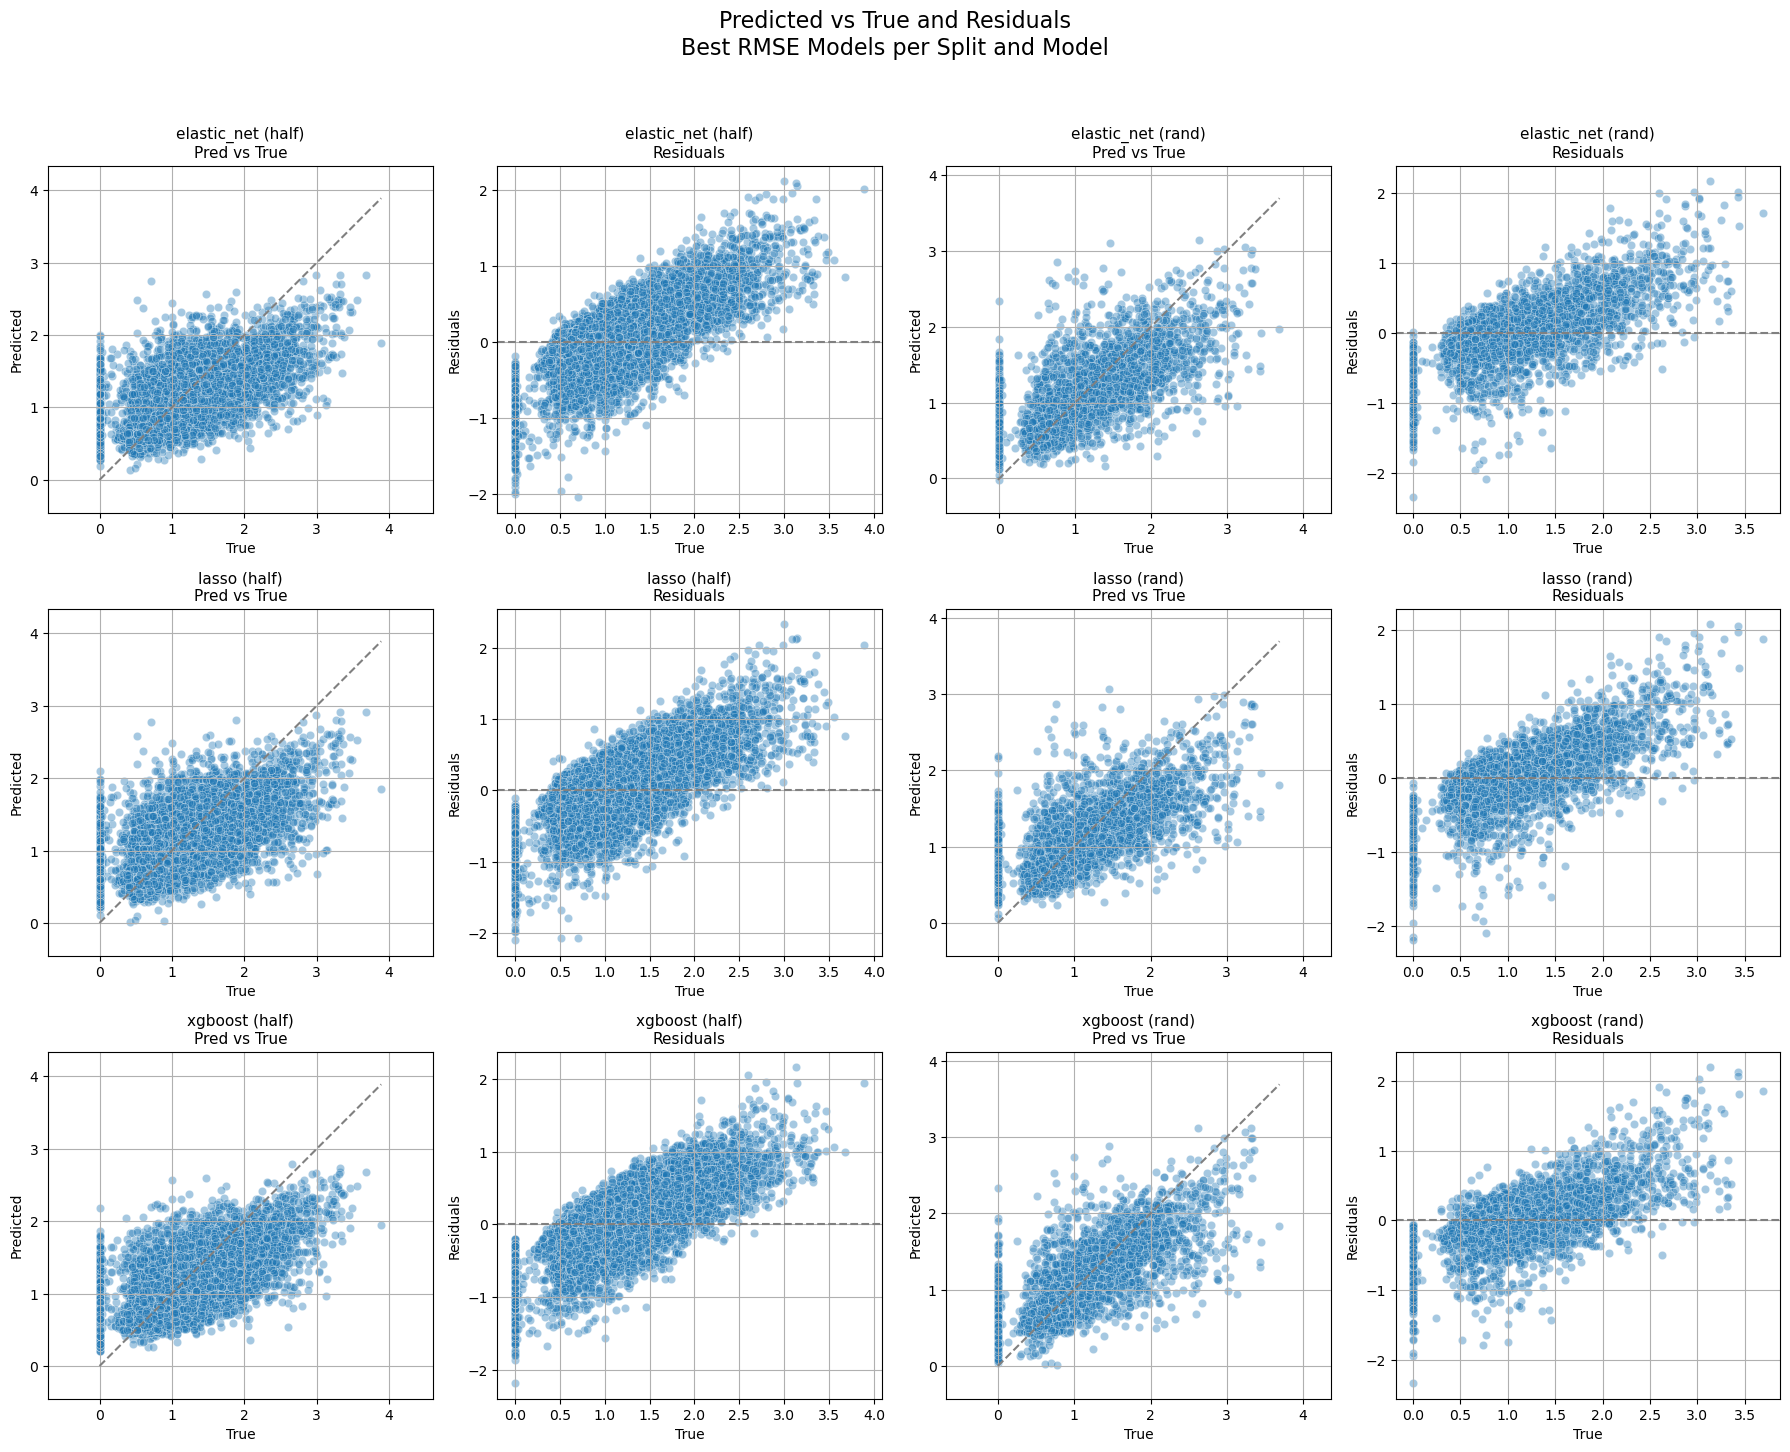

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Config ---
# task = "V11L12-038_A1_top5sv"
base_path = f"/lustre/groups/ml01/workspace/eirini/pipeline/data/reports/"
save_path = f"/lustre/groups/ml01/workspace/eirini/thesis_plots/viz/{task_name}_scatter_FS.png"
# selected_models = ['elastic_net', 'lasso', 'ridge', 'xgboost', 'gnn']
selected_models = ['elastic_net', 'lasso', 'xgboost']

# --- Prepare data ---
# --- Parse and group best models by split ---
valid_entries = []

for model in selected_models:
    model_df = merged_df[merged_df["method_name"] == model]
    for task_name in model_df["task"].unique():
        split = 'rand' if 'rand' in task_name else 'half'
        task_df = model_df[model_df["task"] == task_name]
        if not task_df.empty:
            best_row = task_df.loc[task_df["rmse"].idxmin()]
            pred_path = os.path.join(base_path,best_row["task"], model, best_row["featsel"], best_row["hash"], "predictions.tsv")
            if os.path.exists(pred_path):
                valid_entries.append((split, model, best_row, pred_path))

# valid_entries = []
# for model in selected_models:
#     model_df = merged_df[merged_df["method_name"] == model]
#     for task_name in model_df["task"].unique():
#         if task_name.startswith("V11L12-038_A1_half_top5sv"):
#             split = "half"
#         elif task_name.startswith("V11L12-038_A1_rand_top5sv"):
#             split = "rand"
#         else:
#             continue  # Skip irrelevant tasks

#         task_df = model_df[model_df["task"] == task_name]
#         if not task_df.empty:
#             best_row = task_df.loc[task_df["r2"].idxmax()]
#             pred_path = os.path.join(
#                 base_path, best_row["task"], model, best_row["featsel"], best_row["hash"], "predictions.tsv"
#             )
#             if os.path.exists(pred_path):
#                 valid_entries.append((split, model, best_row, pred_path))

# --- Group by model, separate columns for half and rand ---
grouped = {}
for split, model, row, path in valid_entries:
    if model not in grouped:
        grouped[model] = {}
    grouped[model][split] = (row, path)

# --- Prepare plot ---
n_rows = len(grouped)
fig, axs = plt.subplots(n_rows, 4, figsize=(18, 5 * n_rows))
if n_rows == 1:
    axs = [axs]

# --- Plot ---
for i, (model, split_data) in enumerate(grouped.items()):
    for j, split in enumerate(['half', 'rand']):
        if split not in split_data:
            axs[i][2*j].axis("off")
            axs[i][2*j + 1].axis("off")
            continue

        row, pred_path = split_data[split]
        df = pd.read_csv(pred_path, sep="\t")
        residuals = df["y_true"] - df["y_pred"]

        # Predicted vs True
        ax_pred = axs[i][2*j]
        sns.scatterplot(data=df, x="y_true", y="y_pred", alpha=0.4, ax=ax_pred)
        min_val = min(df["y_true"].min(), df["y_pred"].min())
        max_val = max(df["y_true"].max(), df["y_pred"].max())
        ax_pred.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray")
        ax_pred.set_xlabel("True")
        ax_pred.set_ylabel("Predicted")
        ax_pred.axis("equal")
        ax_pred.grid(True)
        ax_pred.set_title(f"{model} ({split})\nPred vs True", fontsize=11)

        # Residuals
        ax_resid = axs[i][2*j + 1]
        sns.scatterplot(x=df["y_true"], y=residuals, alpha=0.4, ax=ax_resid)
        ax_resid.axhline(0, color="gray", linestyle="--")
        ax_resid.set_xlabel("True")
        ax_resid.set_ylabel("Residuals")
        ax_resid.grid(True)
        ax_resid.set_title(f"{model} ({split})\nResiduals", fontsize=11)

# --- Title and save ---
fig.suptitle(f"Predicted vs True and Residuals\nBest RMSE Models per Split and Model | {task_name}", fontsize=16, y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
# plt.savefig(save_path, dpi=200, bbox_inches="tight")
plt.show()


/tmp/ipykernel_2569534/75400720.py:85: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])
/tmp/ipykernel_2569534/75400720.py:86: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_path, dpi=300, bbox_inches="tight")
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


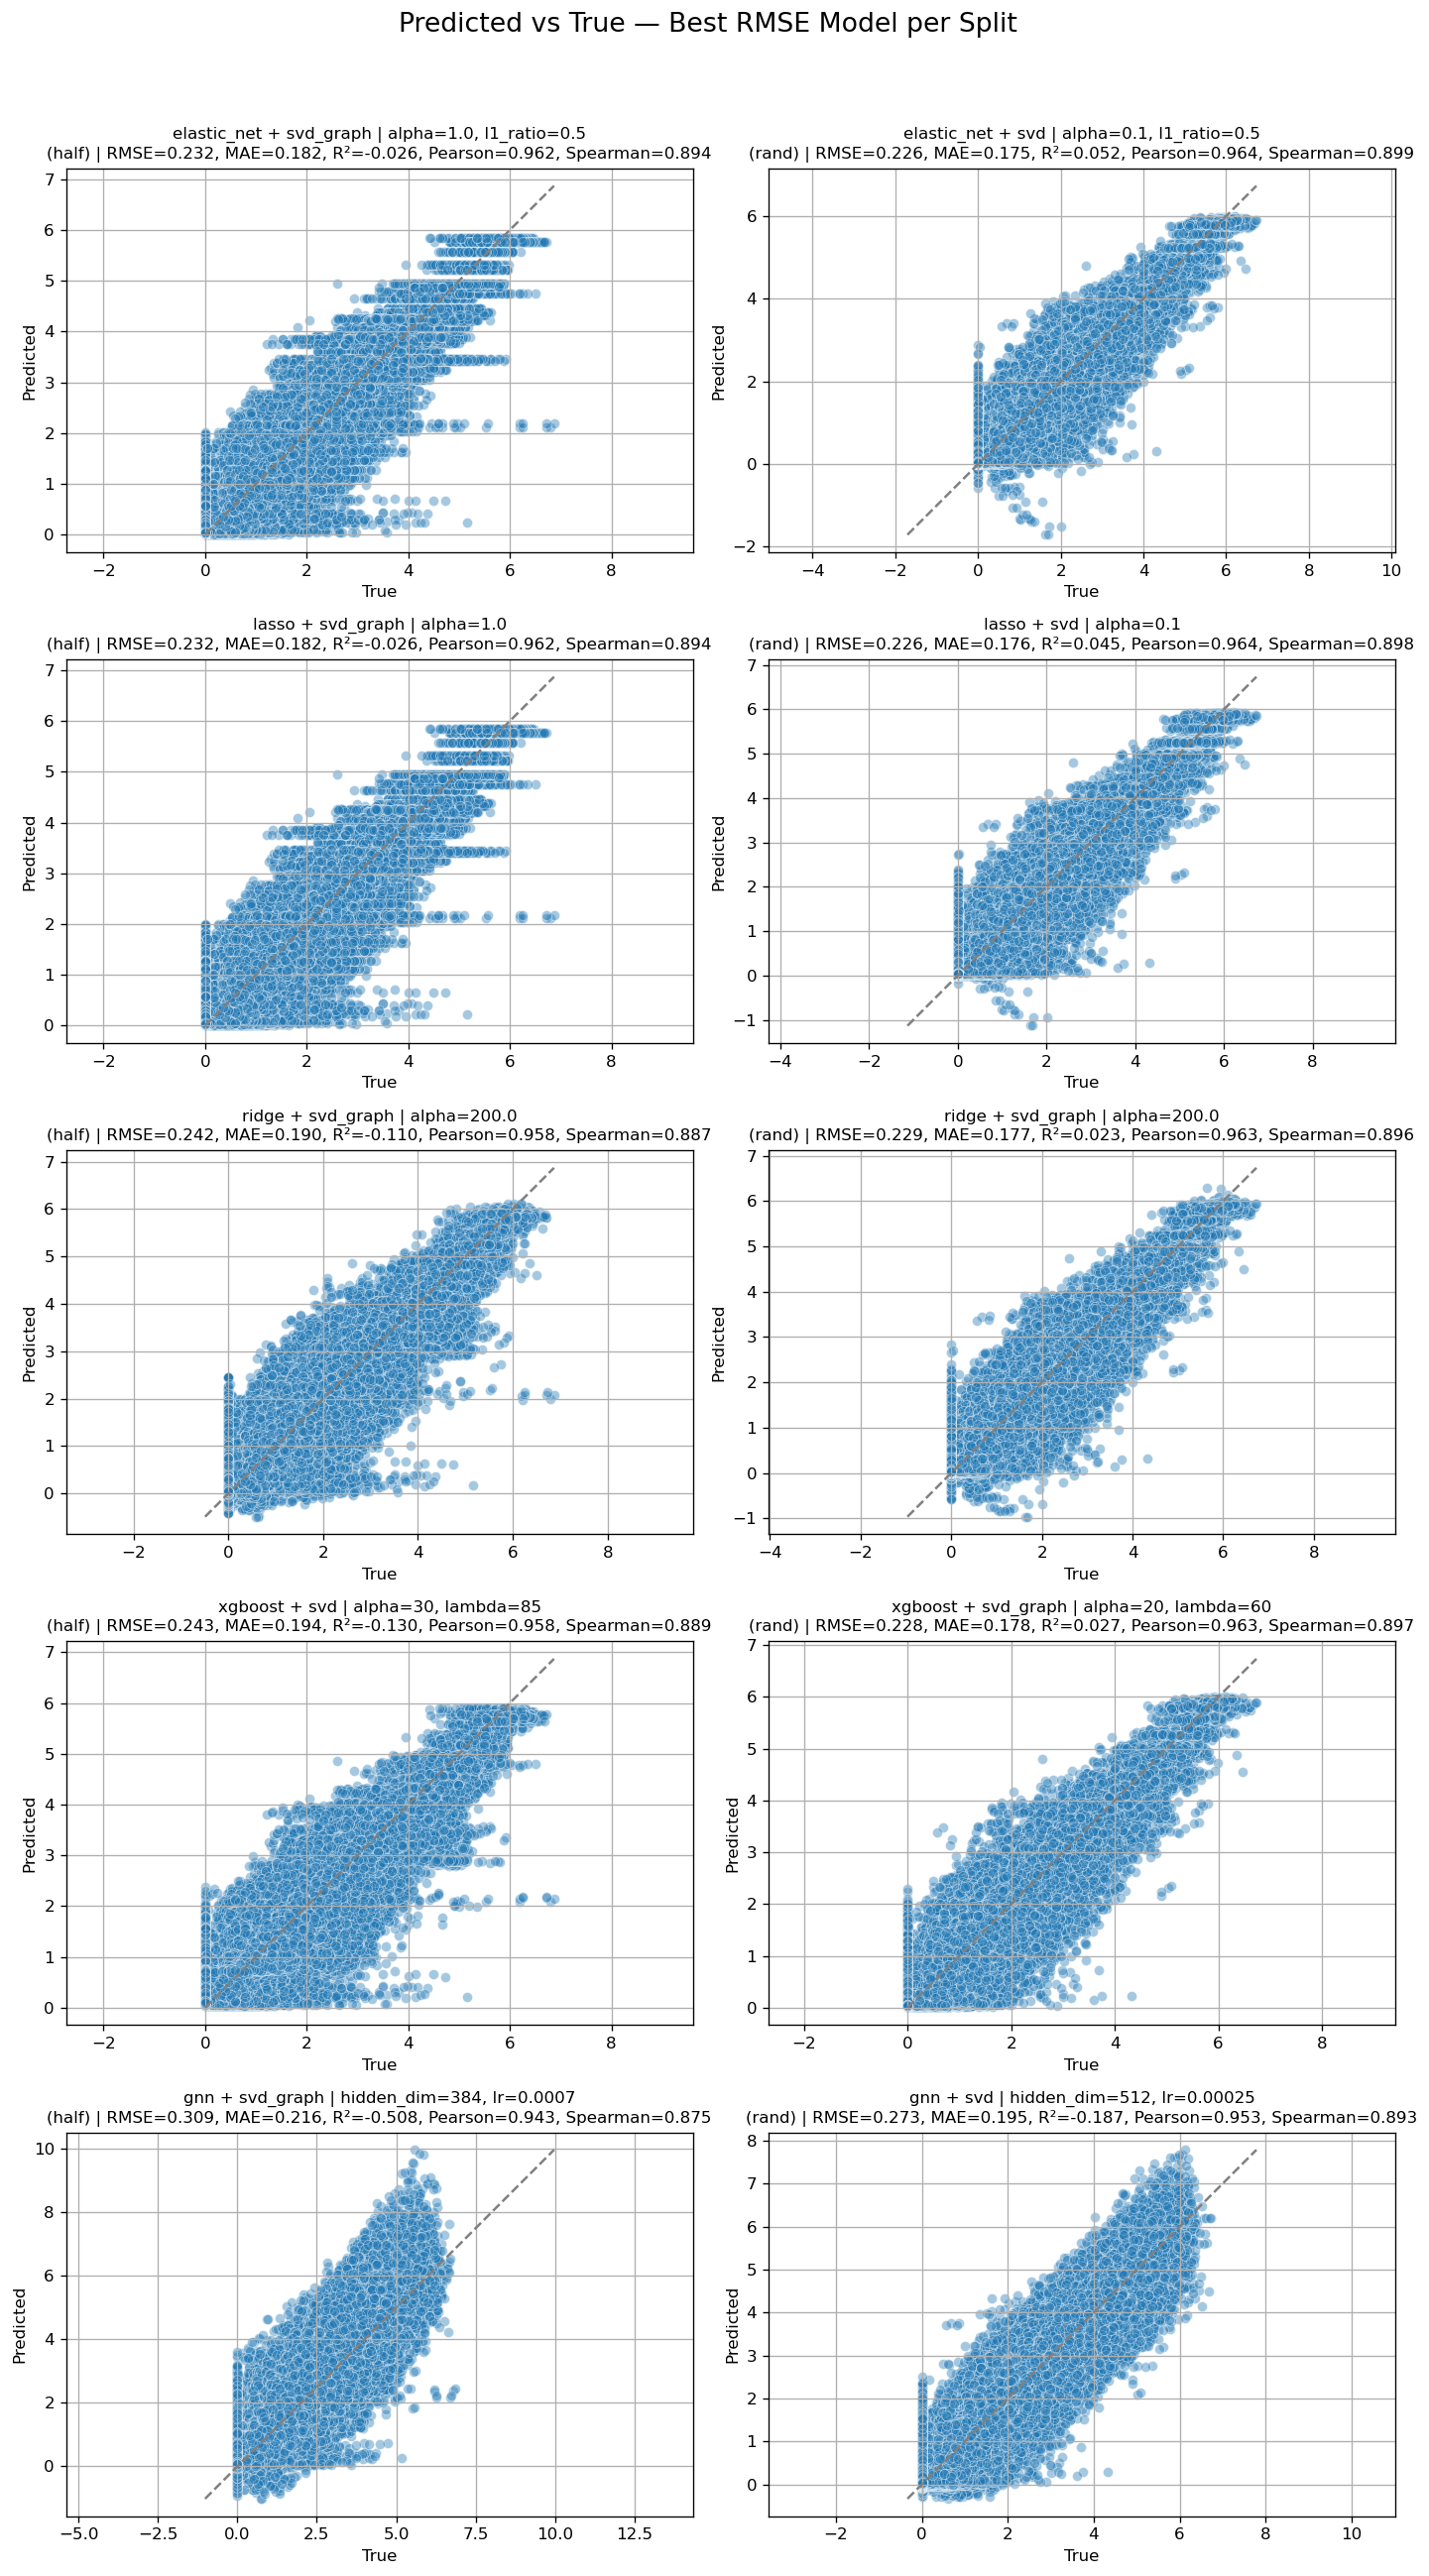

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Config ---
# task = "V11L12-038_A1"
base_path = f"/lustre/groups/ml01/workspace/eirini/pipeline/data/reports/"
save_path = f"/lustre/groups/ml01/workspace/eirini/thesis_plots/viz/{task_name}_scatter_FS_splitgrid_fixed.png"
selected_models = ['elastic_net', 'lasso', 'ridge', 'xgboost', 'gnn']

# --- Load predictions for best RMSE runs ---
valid_entries = []

for model in selected_models:
    model_df = merged_df[merged_df["method_name"] == model]
    for task_name in model_df["task"].unique():
        split = 'rand' if 'rand' in task_name else 'half'
        task_df = model_df[model_df["task"] == task_name]
        if not task_df.empty:
            best_row = task_df.loc[task_df["rmse"].idxmin()]
            pred_path = os.path.join(base_path, best_row["task"], model, best_row["featsel"], best_row["hash"], "predictions.tsv")
            if os.path.exists(pred_path):
                df = pd.read_csv(pred_path, sep="\t")
                df["split"] = split
                df["model"] = model
                df["featsel"] = best_row["featsel"]
                df["method_params"] = best_row["method_params"]
                df["rmse"] = best_row["rmse"]
                df["mae"] = best_row["mae"]
                df["r2"] = best_row["r2"]
                df["pearson"] = best_row["pearson"]
                df["spearman"] = best_row["spearman"]
                valid_entries.append(df)

# --- Combine into one DataFrame ---
scatter_df = pd.concat(valid_entries, ignore_index=True)
n_models = scatter_df['model'].nunique()

# --- Plot grid: rows = models, cols = split ---
fig, axs = plt.subplots(n_models, 2, figsize=(12, 4.5 * n_models), dpi=120)
if n_models == 1:
    axs = [axs]

for i, model in enumerate(selected_models):
    for j, split in enumerate(['half', 'rand']):
        ax = axs[i][j] if n_models > 1 else axs[j]
        df_model = scatter_df[(scatter_df["model"] == model) & (scatter_df["split"] == split)]

        if df_model.empty:
            ax.axis("off")
            continue

        sns.scatterplot(data=df_model, x="y_true", y="y_pred", ax=ax, alpha=0.4, color='tab:blue')
        min_val = min(df_model["y_true"].min(), df_model["y_pred"].min())
        max_val = max(df_model["y_true"].max(), df_model["y_pred"].max())
        ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray")

        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        ax.axis("equal")
        ax.grid(True)
        ax.legend([], [], frameon=False)

        row = df_model.iloc[0]
        method_params = row["method_params"]
        param_info = ""
        if isinstance(method_params, str):
            try:
                param_dict = eval(method_params)
                items = list(param_dict.items())
                param_info = ", ".join([f"{k}={v}" for k, v in items[:2]])
            except:
                pass

        ax.set_title(
            f"{model} + {row['featsel']} | {param_info}\n"
            f"({split}) | RMSE={row['rmse']:.3f}, MAE={row['mae']:.3f}, R²={row['r2']:.3f}, "
            f"Pearson={row['pearson']:.3f}, Spearman={row['spearman']:.3f}",
            fontsize=10
        )

# --- Supertitle and layout ---
fig.suptitle(f"Predicted vs True — Best RMSE Model per Split | {task_name}", fontsize=16, y=0.990)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
# plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()


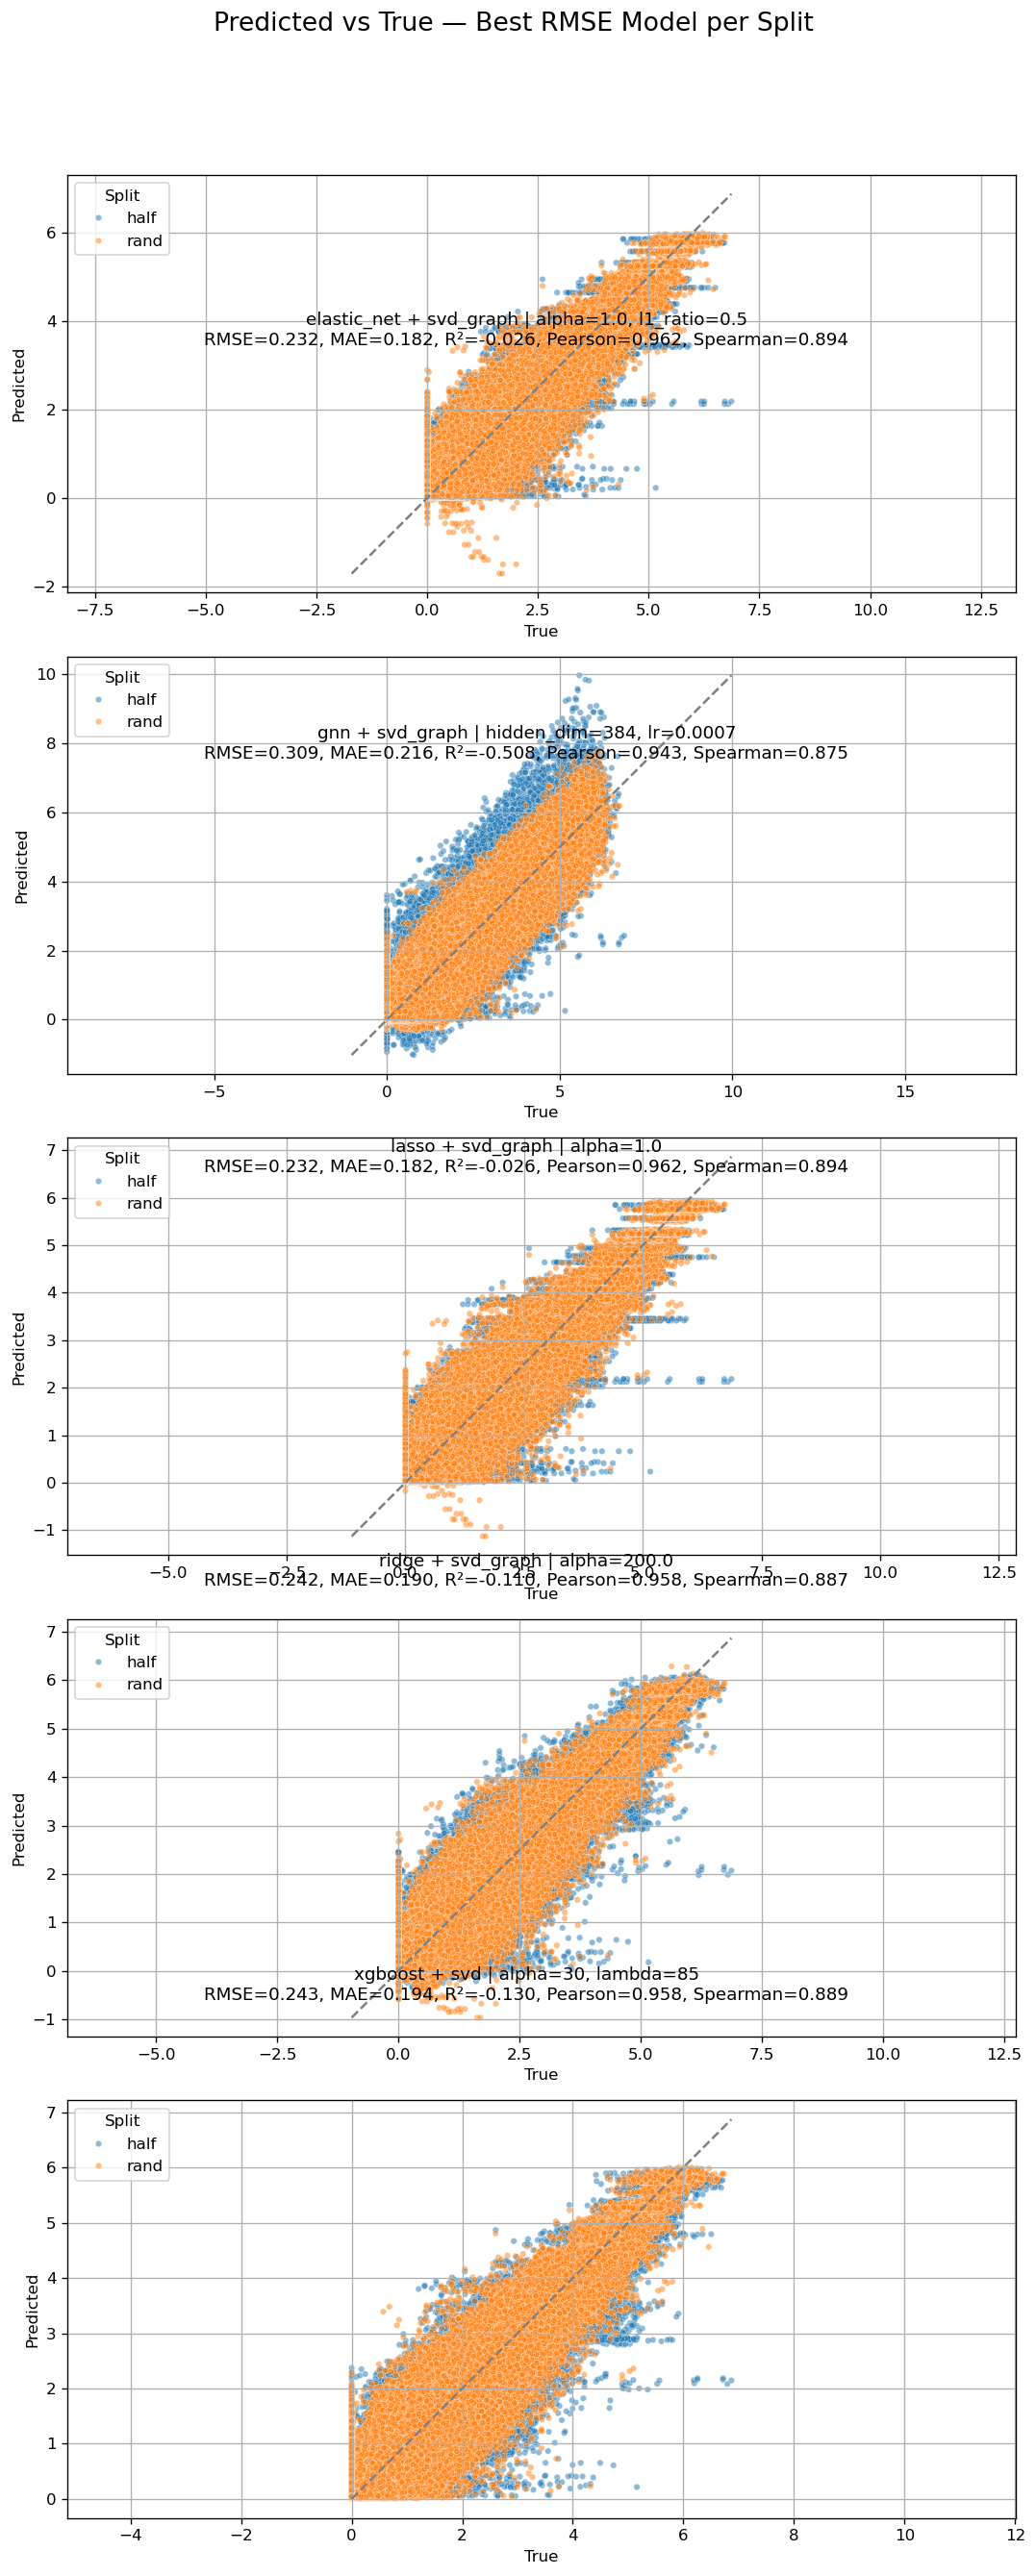

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Config ---
task = "V11L12-038_A1"
base_path = f"/lustre/groups/ml01/workspace/eirini/pipeline/data/reports/"
save_path = f"/lustre/groups/ml01/workspace/eirini/thesis_plots/viz/{task}_scatter_FS_hue.png"
selected_models = ['elastic_net', 'lasso', 'ridge', 'xgboost', 'gnn']

# --- Prepare data ---
valid_entries = []

for model in selected_models:
    model_df = merged_df[merged_df["method_name"] == model]
    for task_name in model_df["task"].unique():
        split = 'rand' if 'rand' in task_name else 'half'
        task_df = model_df[model_df["task"] == task_name]
        if not task_df.empty:
            best_row = task_df.loc[task_df["rmse"].idxmin()]
            pred_path = os.path.join(base_path, best_row["task"], model, best_row["featsel"], best_row["hash"], "predictions.tsv")
            if os.path.exists(pred_path):
                df = pd.read_csv(pred_path, sep="\t")
                df["split"] = split
                df["model"] = model
                df["featsel"] = best_row["featsel"]
                df["method_params"] = best_row["method_params"]
                df["rmse"] = best_row["rmse"]
                df["mae"] = best_row["mae"]
                df["r2"] = best_row["r2"]
                df["pearson"] = best_row["pearson"]
                df["spearman"] = best_row["spearman"]
                valid_entries.append(df)

# --- Combine all into one dataframe ---
scatter_df = pd.concat(valid_entries, ignore_index=True)
n_models = scatter_df['model'].nunique()

# --- Plot ---
fig, axs = plt.subplots(n_models, 1, figsize=(9, 4.5 * n_models), dpi=120)
if n_models == 1:
    axs = [axs]

for i, (model, df_model) in enumerate(scatter_df.groupby("model")):
    ax = axs[i]
    sns.scatterplot(data=df_model, x="y_true", y="y_pred", hue="split", ax=ax, alpha=0.5, s=15)
    
    # Diagonal reference line
    min_val = min(df_model["y_true"].min(), df_model["y_pred"].min())
    max_val = max(df_model["y_true"].max(), df_model["y_pred"].max())
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="gray")
    
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.axis("equal")
    ax.grid(True)
    ax.legend(loc="upper left", title="Split")

    # Get best row for title content (half or rand doesn't matter here)
    best_row = df_model.iloc[0]
    feature_selection = best_row["featsel"]
    method_params = best_row["method_params"]

    param_info = ""
    if isinstance(method_params, str):
        try:
            param_dict = eval(method_params)
            items = list(param_dict.items())
            param_info = ", ".join([f"{k}={v}" for k, v in items[:2]])
        except:
            pass

    # Annotate above subplot
    bbox = ax.get_position()
    x_center = (bbox.x0 + bbox.x1) / 2
    y_top = bbox.y1 + 0.01

    fig.text(
        x_center, y_top,
        f"{model} + {feature_selection} | {param_info}\n"
        f"RMSE={best_row['rmse']:.3f}, MAE={best_row['mae']:.3f}, R²={best_row['r2']:.3f}, "
        f"Pearson={best_row['pearson']:.3f}, Spearman={best_row['spearman']:.3f}",
        ha="center", va="bottom", fontsize=11
    )

# --- Supertitle and layout ---
fig.suptitle("Predicted vs True — Best RMSE Model per Split", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
# plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
